In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, TimeDistributed
from keras import optimizers

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
raw_data = np.loadtxt(open("EEG.csv", "rb"), delimiter=",", skiprows=0)
X_raw = raw_data[:,:-1]

# Data cleaning on X
upper_threshold = 4800
lower_threshold = 3800
too_big = X_raw>upper_threshold
too_small = X_raw<lower_threshold
X_cleaned = np.copy(X_raw)
X_cleaned[too_big] = upper_threshold
X_cleaned[too_small] = lower_threshold

X_toPCA = (X_cleaned - np.mean(X_cleaned)) / np.std(X_cleaned)
y = raw_data[:,-1]

In [3]:
pca = PCA(n_components=3)
X = pca.fit_transform(X_toPCA)

In [4]:
np.sum(pca.explained_variance_ratio_[:3])

0.8183383196839602

In [17]:
num_train = 7000
num_val = 7000
#num_test = 4000
X_train = X[:num_train,:]
y_train = y[:num_train]
X_val = X[num_train:num_train+num_val,:]
y_val = y[num_train:num_train+num_val]
#X_test = X[num_train+num_val:num_train+num_val+num_test,:]
#y_test = y[num_train+num_val:num_train+num_val+num_test]

In [18]:
time_step = 100
batch_size = 70
train_batch_size = int(num_train/time_step)
X_train_batch = np.zeros((train_batch_size,time_step,X.shape[-1]))
y_train_batch = np.zeros((train_batch_size,time_step))
for i in range(time_step):
    X_train_batch[:,i,:] = X_train[i*train_batch_size:(i+1)*train_batch_size,:]
    y_train_batch[:,i] = y_train[i*train_batch_size:(i+1)*train_batch_size]

val_batch_size = int(num_val/time_step)
X_val_batch = np.zeros((val_batch_size,time_step,X.shape[-1]))
y_val_batch = np.zeros((val_batch_size,time_step))
for i in range(time_step):
    X_val_batch[:,i,:] = X_val[i*val_batch_size:(i+1)*val_batch_size,:]
    y_val_batch[:,i] = y_val[i*val_batch_size:(i+1)*val_batch_size]
    
#test_batch_size = int(num_test/time_step)
#X_test_batch = np.zeros((test_batch_size,time_step,X.shape[-1]))
#y_test_batch = np.zeros((test_batch_size,time_step))
#for i in range(time_step):
#    X_test_batch[:,i,:] = X_test[i*test_batch_size:(i+1)*test_batch_size,:]
#    y_test_batch[:,i] = y_test[i*test_batch_size:(i+1)*test_batch_size]
    
y_train_batch = y_train_batch.reshape((y_train_batch.shape[0],y_train_batch.shape[1],1))
y_val_batch = y_val_batch.reshape((y_val_batch.shape[0],y_val_batch.shape[1],1))
#y_test_batch = y_test_batch.reshape((y_test_batch.shape[0],y_test_batch.shape[1],1))

In [19]:
model = Sequential()
model.add(GRU(256,return_sequences=True, stateful = True,activation = 'tanh',batch_input_shape=(batch_size,time_step,X.shape[-1])))
model.add(Dropout(0.5))
model.add(GRU(128,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))
model.add(GRU(32,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))
#model.add(GRU(32,return_sequences=True, stateful = True,activation = 'tanh'))
#model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1,activation = "sigmoid")))
adam = optimizers.Adam(lr=1e-3,decay=1e-6)
model.compile(optimizer = adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train_batch, y_train_batch,validation_data = (X_val_batch,y_val_batch), epochs=40, batch_size=batch_size)

Train on 70 samples, validate on 70 samples
Epoch 1/40
70/70 [==============================] - 4s - loss: 0.6928 - acc: 0.5101 - val_loss: 0.6880 - val_acc: 0.5894
Epoch 2/40
70/70 [==============================] - 1s - loss: 0.6768 - acc: 0.7347 - val_loss: 0.6818 - val_acc: 0.6116
Epoch 3/40
70/70 [==============================] - 1s - loss: 0.6553 - acc: 0.7826 - val_loss: 0.6756 - val_acc: 0.6084
Epoch 4/40
70/70 [==============================] - 1s - loss: 0.6339 - acc: 0.7974 - val_loss: 0.6698 - val_acc: 0.5984
Epoch 5/40
70/70 [==============================] - 1s - loss: 0.6078 - acc: 0.8091 - val_loss: 0.6657 - val_acc: 0.5917
Epoch 6/40
70/70 [==============================] - 1s - loss: 0.5800 - acc: 0.8131 - val_loss: 0.6667 - val_acc: 0.5886
Epoch 7/40
70/70 [==============================] - 2s - loss: 0.5455 - acc: 0.8111 - val_loss: 0.6818 - val_acc: 0.5907
Epoch 8/40
70/70 [==============================] - 2s - loss: 0.5132 - acc: 0.7999 - val_loss: 0.7119 - val_

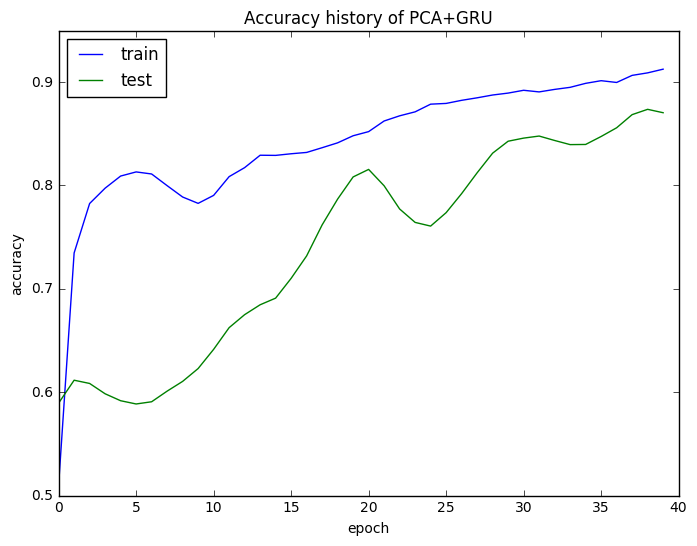

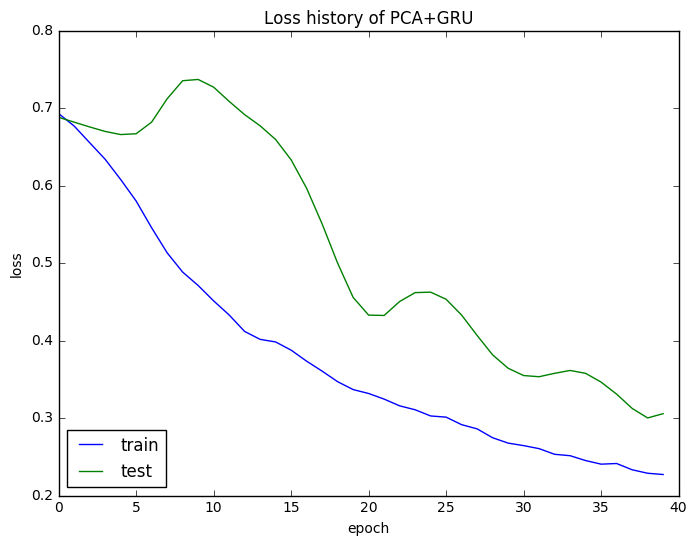

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy history of PCA+GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss history of PCA+GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
score = model.evaluate(X_test_batch, y_test_batch, batch_size=batch_size)

In [ ]:
score